In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve
def cross_validate_learning_rate(estimator, x_train, y_train, cv = 5, scoring = 'roc_auc', return_train_score = True):
    results = cross_validate(estimator,
                            x_train,
                            y_train,
                            cv = cv,
                            scoring=scoring,
                            return_train_score = return_train_score ) 
    train_scores = results['train_score']
    test_scores = results['test_score']
    print("train_scores: {}".format(np.mean(train_scores)))
    print("test_scores: {}".format(np.mean(test_scores)))

    lc = learning_curve(estimator, 
                        x_train, 
                        y_train, 
                        cv=cv, 
                        scoring=scoring)
    samples, train, test = lc[0],lc[1],lc[2]
    plt.plot(samples, np.mean(train, axis=1))
    plt.plot(samples, np.mean(test, axis=1))

In [3]:
from sklearn.model_selection import GridSearchCV
def grid_search_param(X, y,nfolds, param_grid, model_sklearn, scoring = 'roc_auc'):
    grid_search = GridSearchCV(model_sklearn, param_grid, cv=nfolds, return_train_score=True, scoring=scoring)
    grid_search.fit(X, y)
    return grid_search

In [4]:
path = '../data'
y_train = pd.read_csv(f'{path}/y_train.csv', index_col = 'key_value')

In [5]:
list_train_probs = []
list_train_probs.append(pd.read_pickle('train_probs_lightgbm.pkl'))
list_train_probs.append(pd.read_pickle('train_probs_catboost.pkl'))
list_train_probs.append(pd.read_pickle('train_probs_gbc.pkl'))
list_train_probs.append(pd.read_pickle('train_probs_lightgbm_cf.pkl'))
# list_train_probs.append(pd.read_pickle('train_probs_lr.pkl'))
list_train_probs.append(pd.read_pickle('train_probs_rf.pkl'))
train = pd.concat(list_train_probs, axis=1)
train.columns = ['probs_lightgbm', 'probs_catboost', 'probs_gbc', 'probs_lightgbm_cf', 'probs_rf']

In [6]:
list_test_probs = []
list_test_probs.append(pd.read_pickle('test_probs_lightgbm.pkl'))
list_test_probs.append(pd.read_pickle('test_probs_catboost.pkl'))
list_test_probs.append(pd.read_pickle('test_probs_gbc.pkl'))
list_test_probs.append(pd.read_pickle('test_probs_lightgbm_cf.pkl'))
# list_test_probs.append(pd.read_pickle('test_probs_lr.pkl'))
list_test_probs.append(pd.read_pickle('test_probs_rf.pkl'))
test = pd.concat(list_test_probs, axis=1)
test.columns  = ['probs_lightgbm', 'probs_catboost', 'probs_gbc', 'probs_lightgbm_cf', 'probs_rf']

In [7]:
keep_columns = ['probs_lightgbm', 'probs_lightgbm_cf']
train = train[keep_columns]
test = test[keep_columns]

In [8]:
train.corr()

,probs_lightgbm,probs_lightgbm_cf
probs_lightgbm,1.000000,0.982945
probs_lightgbm_cf,0.982945,1.000000


In [9]:
test.corr()

,probs_lightgbm,probs_lightgbm_cf
probs_lightgbm,1.000000,0.992691
probs_lightgbm_cf,0.992691,1.000000


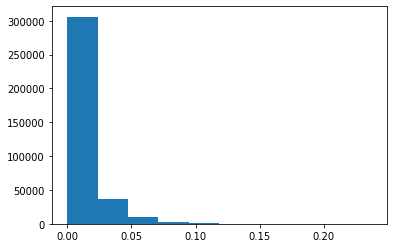

In [10]:
plt.hist(np.std(train.values, axis=1));

### Entrenando el modelo final

train_scores: 0.8548035801727005
test_scores: 0.8547600148986586


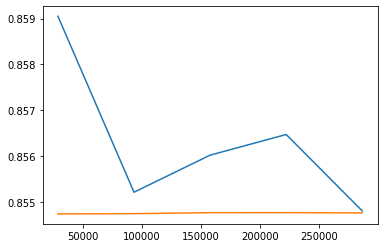

In [11]:
from sklearn.linear_model import LogisticRegression
### definir los parametros a tunear
train = train
Cs = [0.1, 0.3, 0.8, 0.9, 1.0]
# https://neurtu.readthedocs.io/examples/logistic_regression_scaling.html
solvers = ['lbfgs','saga','newton-cg'] # newton-cg, sag, lbfgs, liblinear, saga
param_grid = {'C': Cs,'solver':solvers}
### encontrando los hiper_parámetros
fitting=grid_search_param(train, y_train.target, 5,param_grid, LogisticRegression(penalty="l2", tol=0.0001, random_state=42), scoring='roc_auc')
### instanciar el estimador
estimator = fitting.best_estimator_
#     print(estimator)
### aplicar cross_validate y learning_rate 
cross_validate_learning_rate(estimator, train, y_train.target, scoring='roc_auc')

In [12]:
print(estimator)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)


In [13]:
estimator.coef_

array([[4.06624332, 2.54368855]])

In [14]:
test_stacking = pd.Series(estimator.predict_proba(test)[:,-1], index=test.index, name = 'target')
test_stacking

key_value
0         0.045224
1         0.060810
2         0.053387
3         0.595391
4         0.105093
            ...   
396661    0.068024
396662    0.160790
396663    0.188248
396664    0.057864
396665    0.054794
Name: target, Length: 396666, dtype: float64

In [15]:
test_stacking.to_csv("../results/stacking_2models_LGBM2_0.85476.csv")  ### score de 0.85700  en la tabla publica

In [26]:
# test_stacking.to_csv("../results/stacking_5models_LGBM2_CB_GBC_RF_0.85404.csv")  ### score de ******  en la tabla publica
# test_stacking.to_csv("../results/stacking_5models_LGBM2_CB_GBC_LR_0.85509.csv")  ### score de 0.85572  en la tabla publica
# test_stacking.to_csv("../results/stacking_4models_LGBM2_CB_GBC_0.85520.csv")  ### score de 0.85600 en la tabla publica
# test_stacking.to_csv("../results/stacking_4models_LGBM2_CB_GBC_0.85583.csv")  ### score de 0.85418 en la tabla publica

In [ ]:
# test_stacking.to_csv("../results/stacking_4models_LGBM2_CB_GBC_0.85517.csv")  ### score de 0.85601 en la tabla publica
# test_stacking.to_csv("../results/stacking_3models_LGBM_CB_GBC_0.85473.csv")  ### score de 0.85557 en la tabla publica
# test_stacking.to_csv("../results/stacking_5models_LGBM2_CB_XGB_GBC_0.85523.csv")  ### score de 0.85448 en la tabla publica
# test_stacking.to_csv("../results/stacking_3models_LGBM2_CB_0.85512.csv")  ### score de 0.85592 en la tabla publica

In [ ]:
# test_stacking.to_csv("../results/stacking_4models_LGBM2_CB_XGB_0.85464.csv")  ### score de 0.85596 en la tabla publica
# test_stacking.to_csv("../results/stacking_2models_LGBM_CB_0.85419.csv")  ### score de 0.85567 en la tabla publica

In [ ]:
# test_stacking.to_csv("../results/stacking_3models_LGBM2_GBC_0.84805.csv")  ### score de 0.84996 en la tabla publica
# test_stacking.to_csv("../results/stacking_3models_LGBM2_R_0.84729.csv")  ### score de 0.84927 en la tabla publica
# test_stacking.to_csv("../results/stacking_6models_0.84767.csv")  ### score de 0.84910 en la tabla publica
# test_stacking.to_csv("../results/stacking_3models_LGBM2_RNN_0.84830.csv")  ### score de 0.84974 en la tabla publica
# test_stacking.to_csv("../results/stacking_3models_LGBM2_RF_0.84694.csv")  ### score de 0.84874  en la tabla publica
# test_stacking.to_csv("../results/stacking_3models_LGBM2_XGB_0.84807.csv")  ### score de 0.84977  en la tabla publica
# test_stacking.to_csv("../results/stacking_3models_LGBM2_0.84811.csv")  ### score de 0.84970  en la tabla publica
# test_stacking.to_csv("../results/stacking_2models_LGBM2_0.84801.csv")  ### score de 0.84992 en la tabla publica
# test_stacking.to_csv("../results/stacking_3models_CB_LGBM2_0.84834.csv")  ### score de 0.84991 en la tabla publica
# test_stacking.to_csv("../results/stacking_3models_CB_LGBM2_0.84833.csv") ### score de 0.84992 en la tabla publica
# test_stacking.to_csv("../results/stacking_2models_CB_LGBM_0.84721.csv") ### score de 0.84882 en la tabla publica

In [ ]:
### Por lo que se puede concluir que los dos modelos de lightGBM (el normal, y el que toma en cuenta las categoricas).
### Tienen mejor performance